In [14]:
from fastcore.xtras import load_pickle
import pandas as pd 
import os 
from glob import glob
from pathlib import Path
from scipy.stats import sem
import matplotlib.pyplot as plt
from datetime import datetime
import sys
sys.path.append("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/")

plt.style.use("/home/jorenvanherck/Documents/gptchallengeV2/gptchem-gptj/plotutils/kevin.mplstyle")

FOLDER = 'out'

In [15]:
if not os.path.exists(FOLDER):
    raise FileExistsError('Cannot find folder {}'.format(FOLDER))

all_res = glob(f'{FOLDER}/*.pkl')
print('Pickles found in {}: {}'.format(FOLDER, len(all_res)))

Pickles found in out: 133


In [16]:

compiled_res_list = []
conf_mats = []

for results in all_res:
    res_full = load_pickle(results)
    res = res_full['results']
    summary = {
        'size': res_full['train_size'],
        'representation': res_full['data_summary']['representation'],
        'target': res_full['data_summary']['target'],
        'accuracy': res['accuracy'],
        'f1_macro': res['f1_macro'],
        'f1_micro': res['f1_micro'],
        'kappa': res['kappa'],
        'num_epochs': res_full['config']['tune_settings']['num_train_epochs'],
        'lr': res_full['config']['tune_settings']['learning_rate'],
        'bins': len(set(res['all_y_true']))
       
    }
    confusion_matrix = {
        'all_y_true':res['all_y_true'],
        'all_y_pred':res['all_y_pred']
    }
    conf_mats.append(confusion_matrix)
    compiled_res_list.append(summary)


In [17]:
compiled_res = pd.DataFrame(compiled_res_list)
compiled_res = compiled_res[compiled_res['target'] == 'binary_Heat']
compiled_res = compiled_res[compiled_res['num_epochs'] == 50]
#compiled_res = compiled_res[compiled_res['size'] == 350]
compiled_res = compiled_res[compiled_res['lr'] == 0.00030]

compiled_res = compiled_res.drop('target', axis=1)
grouped_res =compiled_res.groupby(['bins', 'num_epochs','representation', 'size']).agg(['mean', 'sem'])


In [18]:
grouped_res


accuracy            f1_macro  \
                                                   mean       sem      mean   
bins num_epochs representation           size                                 
2    50         Composition_Formula      350   0.846667  0.013333  0.846263   
                Equilibrium_Pressure_25C 350   0.740000  0.030551  0.737897   
                element                  350   0.720000  0.040000  0.718626   
                formula_eqPressure_25C   100   0.680000  0.020000  0.659613   
                                         200   0.746667  0.006667  0.743543   
                                         300   0.793333  0.029059  0.791943   
                                         350   0.786667  0.006667  0.784923   

                                                         f1_micro            \
                                                    sem      mean       sem   
bins num_epochs representation           size                                 
2    50         Composition_Formula      350   0.013457  0.846667  0.013333   
                Equilibrium_Pressure_25C 350   0.031893  0.740000  0.030551   
                element                  350   0.040687  0.720000  0.040000   
                formula_eqPressure_25C   100   0.030341  0.680000  0.020000   
                                         200   0.007492  0.746667  0.006667   
                                         300   0.029745  0.793333  0.029059   
                                         350   0.006109  0.786667  0.006667   

                                                  kappa                lr       
                                                   mean       sem    mean  sem  
bins num_epochs representation           size                                   
2    50         Composition_Formula      350   0.693333  0.026667  0.0003  0.0  
                Equilibrium_Pressure_25C 350   0.480000  0.061101  0.0003  0.0  
                element                  350   0.440000  0.080000  0.0003  0.0  
                formula_eqPressure_25C   100   0.360000  0.040000  0.0003  0.0  
                                         200   0.493333  0.013333  0.0003  0.0  
                                         300   0.586667  0.058119  0.0003  0.0  
                                         350   0.573333  0.013333  0.0003  0.0

/home/jorenvanherck/.local/lib/python3.10/site-packages/matplotlib/ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)
/home/jorenvanherck/.local/lib/python3.10/site-packages/matplotlib/ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


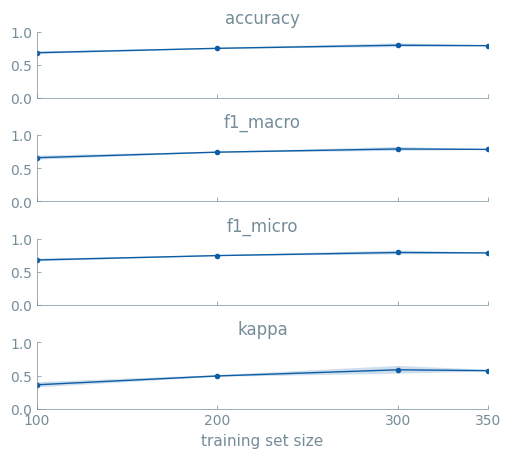

In [19]:
from scipy.stats import sem
from scipy.constants import golden


FOLDER = 'out'

ONE_COL_WIDTH_INCH = 5
TWO_COL_WIDTH_INCH = 7.2

ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

BINS = 2
REPRESENTATION = 'formula_eqPressure_25C'

fig, ax = plt.subplots(4, 1,figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH),constrained_layout = True , sharex=True)
 
for num_epochs in [50]:
    for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
        ax[i].plot(
            grouped_res.loc[BINS, num_epochs,REPRESENTATION].index, 
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'],
            marker='o',
            label=f'{num_epochs} epochs'
        )
        ax[i].fill_between(
            grouped_res.loc[BINS, num_epochs,REPRESENTATION].index,
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] - grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
            grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['mean'] + grouped_res.loc[BINS, num_epochs,REPRESENTATION][metric]['sem'],
            alpha=0.2
        )
        ax[i].set_ylim(0,1)
        ax[i].set_title(metric)
        ax[i].set_xticks((list(compiled_res['size'].unique())))
    #ylabel_top('accuracy', ax=ax[0])
    #ylabel_top(r'F$_1$ macro', ax=ax[1])
    #ylabel_top(r'F$_1$ micro', ax=ax[2])
    #ylabel_top(r'$\kappa$', ax=ax[3])
ax[-1].set_xlabel('training set size')


#matplotx.line_labels(ax[0])
now = datetime.now().strftime('%Y%m%d_%H%M') 
#fig.suptitle('Hydrides - {} - {}'.format(REPRESENTATION, 'binary'), fontsize=16)
fig.savefig(f'hydrides-{REPRESENTATION}-binary-{BINS}bin-classification-results.pdf', bbox_inches='tight')

/home/jorenvanherck/.local/lib/python3.10/site-packages/matplotlib/ticker.py:2954: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


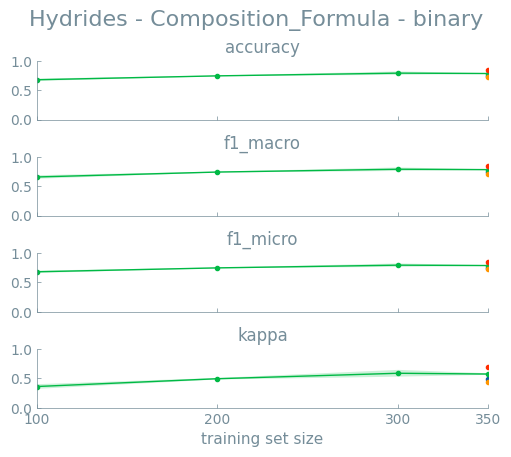

In [20]:
from scipy.stats import sem
from scipy.constants import golden

ONE_COL_WIDTH_INCH = 5
TWO_COL_WIDTH_INCH = 7.2

ONE_COL_GOLDEN_RATIO_HEIGHT_INCH = ONE_COL_WIDTH_INCH / golden
TWO_COL_GOLDEN_RATIO_HEIGHT_INCH = TWO_COL_WIDTH_INCH / golden

BINS = 2
num_epochs = 50

fig, ax = plt.subplots(4, 1,figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH),constrained_layout = True , sharex=True)
 
for re in compiled_res['representation'].unique():
    sub_df = grouped_res.loc[BINS, num_epochs, re]

    for i, metric in enumerate(['accuracy', 'f1_macro', 'f1_micro', 'kappa']):
        ax[i].plot(
            sub_df.index, 
            sub_df[metric]['mean'],
            marker='o',
            label=f'{num_epochs} epochs'
        )
        ax[i].fill_between(
            sub_df.index,
            sub_df[metric]['mean'] - sub_df[metric]['sem'],
            sub_df[metric]['mean'] + sub_df[metric]['sem'],
            alpha=0.2
        )
        ax[i].set_ylim(0,1)
        ax[i].set_title(metric)
        ax[i].set_xticks((list(compiled_res['size'].unique())))
    #ylabel_top('accuracy', ax=ax[0])
    #ylabel_top(r'F$_1$ macro', ax=ax[1])
    #ylabel_top(r'F$_1$ micro', ax=ax[2])
    #ylabel_top(r'$\kappa$', ax=ax[3])
ax[-1].set_xlabel('training set size')


#matplotx.line_labels(ax[0])
now = datetime.now().strftime('%Y%m%d_%H%M') 
fig.suptitle('Hydrides - {} - {}'.format(re, 'binary'), fontsize=16)
fig.savefig(f'hydrides-{re}-binary-{BINS}bin-classification-results.pdf', bbox_inches='tight')